***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
image_dir = Path('./Imagenes/Trayectorias_dominio_tiempo_frecuencia/longitud_8/raw-img-v3')

file_paths = list(image_dir.rglob("*.jpg")) + \
             list(image_dir.rglob("*.jpeg")) + \
             list(image_dir.rglob("*.png"))

complete_df = pd.DataFrame()
complete_df['file_name'] = [str(p) for p in file_paths]
complete_df['class_name'] = complete_df['file_name'].map(lambda x: Path(x).parent.name)

### COMPROBACIÓN ###
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)


Número total de imágenes: 3884
class_name
Fishing      949
Container    933
Cruise       918
Tanker       688
Cargo        396
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 3110
class_name
Fishing      760
Container    747
Cruise       735
Tanker       551
Cargo        317
Name: count, dtype: int64

Nº de imágenes en test: 774
class_name
Fishing      189
Container    186
Cruise       183
Tanker       137
Cargo         79
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name class_name
0  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
1  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Tanker
2  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
3  Imagenes\Trayectorias_dominio_tiempo_frecuenci...      Cargo
4  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
5  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
6  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
7  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
8  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Tanker
9  Imagenes\Trayectorias_dominio_ti

***Imágenes de entrenamiento y test antes del pre-procesado :***

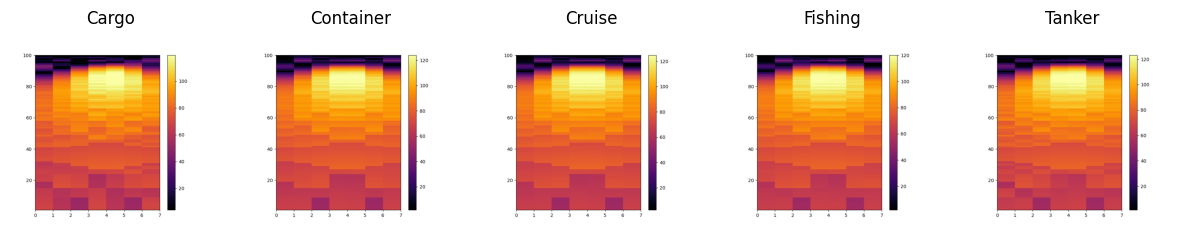

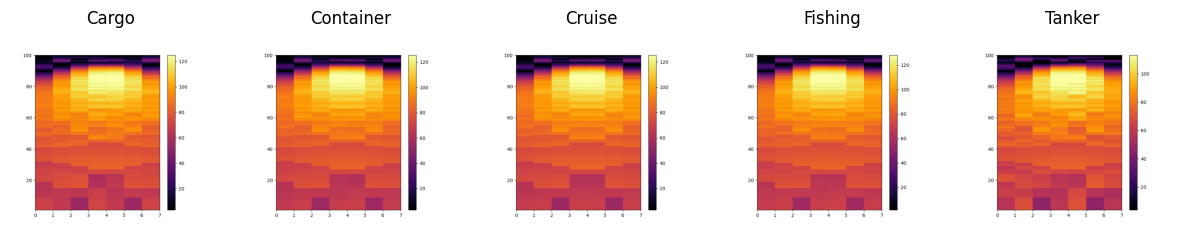

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    grouped = df.groupby('class_name')
    
    for i, (class_name, group) in enumerate(grouped):
        image_path = group['file_name'].iloc[0]
        image = Image.open(image_path).convert("RGB")
        
        plt.subplot(1, len(grouped), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.ToTensor()])

def preprocesado_imagen(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

for index, row in train_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_train.append(image_tensor)
    y_train.append(row['class_name'])

for index, row in test_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_test.append(image_tensor)
    y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

### COMPROBACIÓN ###
print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)


cuda disponible
X_train: torch.Size([3110, 3, 227, 227]) cpu
y_train: torch.Size([3110]) cpu
X_test: torch.Size([774, 3, 227, 227]) cpu
y_test: torch.Size([774]) cpu


# ***AlexNet :***

In [ ]:
def get_alexnet_model(num_classes, pretrained):
    if pretrained:
        modelo = alexnet(weights=AlexNet_Weights.DEFAULT)
    else:
        modelo = alexnet(weights=None)

    modelo.classifier[6] = nn.Linear(modelo.classifier[6].in_features, num_classes)

    if pretrained:
        for param in modelo.features.parameters():
            param.requires_grad = False
            
        for param in modelo.classifier[6].parameters():
            param.requires_grad = True

    return modelo

# ***ResNet50 :***

In [ ]:
def get_resnet50_model(num_classes, pretrained):
    if pretrained:
        modelo = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        modelo = resnet50(weights=None)

    modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.fc.parameters():
            param.requires_grad = True

    return modelo

# ***DenseNet121 :***

In [ ]:
def get_densenet121_model(num_classes, pretrained):
    if pretrained:
        modelo = densenet121(weights=DenseNet121_Weights.DEFAULT)
    else:
        modelo = densenet121(weights=None)

    modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier.parameters():
            param.requires_grad = True

    return modelo

# ***ConvNeXt Tiny :***

In [6]:
def get_convnext_tiny_model(num_classes, pretrained):
    if pretrained:
        modelo = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
    else:
        modelo = convnext_tiny(weights=None)

    modelo.classifier[2] = nn.Linear(modelo.classifier[2].in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier[2].parameters():
            param.requires_grad = True

    return modelo

***Configuración del modelo :***

In [7]:
k_folds = 5
batch_size = 32
num_epochs = 100
num_classes = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

***Entrenamiento del modelo :***

In [8]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

    #nombre_modelo = "AlexNet"
    #modelo = get_alexnet_model(num_classes=num_classes, pretrained=False).to(device)
    
    #nombre_modelo = "ResNet50"
    #modelo = get_resnet50_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "DenseNet121"
    #modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)
    
    nombre_modelo = "ConvNext_Tiny"
    modelo = get_convnext_tiny_model(num_classes=num_classes, pretrained=True).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = modelo(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        modelo.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                output = modelo(images)
                loss = criterion(output, labels)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v3/representacion_3/longitud_8"
        os.makedirs(save_path, exist_ok=True)
        torch.save(modelo.state_dict(), f"{save_path}/{nombre_modelo}_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/100: 100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 20.18% - Train Loss: 1.6281 | Val Acc: 10.13% - Val Loss: 1.6173


Fold 1 | Epoch 2/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 19.25% - Train Loss: 1.6391 | Val Acc: 24.12% - Val Loss: 1.6206


Fold 1 | Epoch 3/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 20.54% - Train Loss: 1.6312 | Val Acc: 16.24% - Val Loss: 1.6541


Fold 1 | Epoch 4/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 20.94% - Train Loss: 1.6230 | Val Acc: 24.12% - Val Loss: 1.6213


Fold 1 | Epoch 5/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 20.62% - Train Loss: 1.6277 | Val Acc: 24.60% - Val Loss: 1.6372


Fold 1 | Epoch 6/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 19.77% - Train Loss: 1.6275 | Val Acc: 24.44% - Val Loss: 1.6187


Fold 1 | Epoch 7/100: 100%|██████████| 78/78 [00:14<00:00,  5.48it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 18.89% - Train Loss: 1.6475 | Val Acc: 16.24% - Val Loss: 1.6266


Fold 1 | Epoch 8/100: 100%|██████████| 78/78 [00:14<00:00,  5.33it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 18.85% - Train Loss: 1.6203 | Val Acc: 15.43% - Val Loss: 1.6174


Fold 1 | Epoch 9/100: 100%|██████████| 78/78 [00:14<00:00,  5.28it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 20.18% - Train Loss: 1.6261 | Val Acc: 16.24% - Val Loss: 1.6243


Fold 1 | Epoch 10/100: 100%|██████████| 78/78 [00:14<00:00,  5.30it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 19.29% - Train Loss: 1.6270 | Val Acc: 25.24% - Val Loss: 1.6341


Fold 1 | Epoch 11/100: 100%|██████████| 78/78 [00:16<00:00,  4.70it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 19.65% - Train Loss: 1.6351 | Val Acc: 25.08% - Val Loss: 1.6433


Fold 1 | Epoch 12/100: 100%|██████████| 78/78 [00:15<00:00,  5.03it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 20.78% - Train Loss: 1.6235 | Val Acc: 16.88% - Val Loss: 1.6266


Fold 1 | Epoch 13/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 20.14% - Train Loss: 1.6191 | Val Acc: 10.29% - Val Loss: 1.6326


Fold 1 | Epoch 14/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 21.46% - Train Loss: 1.6182 | Val Acc: 24.44% - Val Loss: 1.6137


Fold 1 | Epoch 15/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 20.22% - Train Loss: 1.6248 | Val Acc: 25.08% - Val Loss: 1.6189


Fold 1 | Epoch 16/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 21.06% - Train Loss: 1.6298 | Val Acc: 20.74% - Val Loss: 1.6623


Fold 1 | Epoch 17/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 19.45% - Train Loss: 1.6323 | Val Acc: 19.13% - Val Loss: 1.6234


Fold 1 | Epoch 18/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 22.95% - Train Loss: 1.6234 | Val Acc: 19.77% - Val Loss: 1.6089


Fold 1 | Epoch 19/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 20.62% - Train Loss: 1.6274 | Val Acc: 10.77% - Val Loss: 1.6464


Fold 1 | Epoch 20/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 20.58% - Train Loss: 1.6284 | Val Acc: 18.01% - Val Loss: 1.6100


Fold 1 | Epoch 21/100: 100%|██████████| 78/78 [00:13<00:00,  5.62it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 21.06% - Train Loss: 1.6209 | Val Acc: 18.01% - Val Loss: 1.6091


Fold 1 | Epoch 22/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 20.82% - Train Loss: 1.6244 | Val Acc: 18.01% - Val Loss: 1.6234


Fold 1 | Epoch 23/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 19.98% - Train Loss: 1.6265 | Val Acc: 18.33% - Val Loss: 1.6303


Fold 1 | Epoch 24/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 21.14% - Train Loss: 1.6250 | Val Acc: 24.92% - Val Loss: 1.6188


Fold 1 | Epoch 25/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 20.94% - Train Loss: 1.6255 | Val Acc: 27.81% - Val Loss: 1.6012


Fold 1 | Epoch 26/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 20.66% - Train Loss: 1.6233 | Val Acc: 22.51% - Val Loss: 1.5989


Fold 1 | Epoch 27/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 21.26% - Train Loss: 1.6128 | Val Acc: 25.24% - Val Loss: 1.6062


Fold 1 | Epoch 28/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 20.82% - Train Loss: 1.6156 | Val Acc: 23.63% - Val Loss: 1.6190


Fold 1 | Epoch 29/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 22.75% - Train Loss: 1.6186 | Val Acc: 18.65% - Val Loss: 1.6045


Fold 1 | Epoch 30/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 21.02% - Train Loss: 1.6184 | Val Acc: 25.72% - Val Loss: 1.6176


Fold 1 | Epoch 31/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 21.95% - Train Loss: 1.6197 | Val Acc: 24.44% - Val Loss: 1.6196


Fold 1 | Epoch 32/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 21.91% - Train Loss: 1.6289 | Val Acc: 20.10% - Val Loss: 1.6278


Fold 1 | Epoch 33/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 20.26% - Train Loss: 1.6237 | Val Acc: 17.04% - Val Loss: 1.6086


Fold 1 | Epoch 34/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 21.46% - Train Loss: 1.6223 | Val Acc: 17.20% - Val Loss: 1.6147


Fold 1 | Epoch 35/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 20.62% - Train Loss: 1.6167 | Val Acc: 18.65% - Val Loss: 1.6082


Fold 1 | Epoch 36/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 21.78% - Train Loss: 1.6256 | Val Acc: 22.19% - Val Loss: 1.6078


Fold 1 | Epoch 37/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 22.27% - Train Loss: 1.6177 | Val Acc: 23.79% - Val Loss: 1.6738


Fold 1 | Epoch 38/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 21.50% - Train Loss: 1.6203 | Val Acc: 24.92% - Val Loss: 1.6055


Fold 1 | Epoch 39/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 21.18% - Train Loss: 1.6192 | Val Acc: 17.68% - Val Loss: 1.6347


Fold 1 | Epoch 40/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 20.22% - Train Loss: 1.6228 | Val Acc: 26.21% - Val Loss: 1.6566


Fold 1 | Epoch 41/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 22.51% - Train Loss: 1.6267 | Val Acc: 22.83% - Val Loss: 1.6079


Fold 1 | Epoch 42/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 20.82% - Train Loss: 1.6170 | Val Acc: 25.40% - Val Loss: 1.6059


Fold 1 | Epoch 43/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 21.22% - Train Loss: 1.6244 | Val Acc: 19.94% - Val Loss: 1.6085


Fold 1 | Epoch 44/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 21.54% - Train Loss: 1.6247 | Val Acc: 26.37% - Val Loss: 1.6152


Fold 1 | Epoch 45/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 20.58% - Train Loss: 1.6275 | Val Acc: 20.58% - Val Loss: 1.6153


Fold 1 | Epoch 46/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 22.11% - Train Loss: 1.6307 | Val Acc: 26.21% - Val Loss: 1.6025


Fold 1 | Epoch 47/100: 100%|██████████| 78/78 [00:14<00:00,  5.49it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 20.26% - Train Loss: 1.6159 | Val Acc: 15.92% - Val Loss: 1.6107


Fold 1 | Epoch 48/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 22.67% - Train Loss: 1.6240 | Val Acc: 21.22% - Val Loss: 1.6539


Fold 1 | Epoch 49/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 22.67% - Train Loss: 1.6159 | Val Acc: 28.30% - Val Loss: 1.6050


Fold 1 | Epoch 50/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 22.83% - Train Loss: 1.6139 | Val Acc: 25.56% - Val Loss: 1.6148


Fold 1 | Epoch 51/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 23.35% - Train Loss: 1.6157 | Val Acc: 21.06% - Val Loss: 1.6257


Fold 1 | Epoch 52/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 20.42% - Train Loss: 1.6201 | Val Acc: 17.85% - Val Loss: 1.6371


Fold 1 | Epoch 53/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 21.38% - Train Loss: 1.6138 | Val Acc: 27.65% - Val Loss: 1.6067


Fold 1 | Epoch 54/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 23.55% - Train Loss: 1.6111 | Val Acc: 21.86% - Val Loss: 1.6277


Fold 1 | Epoch 55/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 22.03% - Train Loss: 1.6274 | Val Acc: 27.17% - Val Loss: 1.6159


Fold 1 | Epoch 56/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 21.30% - Train Loss: 1.6220 | Val Acc: 19.45% - Val Loss: 1.6104


Fold 1 | Epoch 57/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 23.47% - Train Loss: 1.6107 | Val Acc: 16.24% - Val Loss: 1.6920


Fold 1 | Epoch 58/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 22.71% - Train Loss: 1.6130 | Val Acc: 22.99% - Val Loss: 1.6157


Fold 1 | Epoch 59/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 22.55% - Train Loss: 1.6201 | Val Acc: 23.15% - Val Loss: 1.6038


Fold 1 | Epoch 60/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 22.59% - Train Loss: 1.6159 | Val Acc: 23.15% - Val Loss: 1.6012


Fold 1 | Epoch 61/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 21.62% - Train Loss: 1.6204 | Val Acc: 24.60% - Val Loss: 1.6264


Fold 1 | Epoch 62/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 20.66% - Train Loss: 1.6218 | Val Acc: 16.40% - Val Loss: 1.6152


Fold 1 | Epoch 63/100: 100%|██████████| 78/78 [00:13<00:00,  5.63it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 22.75% - Train Loss: 1.6186 | Val Acc: 18.97% - Val Loss: 1.6291


Fold 1 | Epoch 64/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 20.38% - Train Loss: 1.6256 | Val Acc: 23.79% - Val Loss: 1.6291


Fold 1 | Epoch 65/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 22.19% - Train Loss: 1.6239 | Val Acc: 16.24% - Val Loss: 1.6365


Fold 1 | Epoch 66/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 22.91% - Train Loss: 1.6088 | Val Acc: 14.63% - Val Loss: 1.6513


Fold 1 | Epoch 67/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 21.34% - Train Loss: 1.6268 | Val Acc: 25.08% - Val Loss: 1.6114


Fold 1 | Epoch 68/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 23.55% - Train Loss: 1.6113 | Val Acc: 26.37% - Val Loss: 1.5997


Fold 1 | Epoch 69/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 20.66% - Train Loss: 1.6105 | Val Acc: 21.54% - Val Loss: 1.6591


Fold 1 | Epoch 70/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 20.82% - Train Loss: 1.6215 | Val Acc: 27.81% - Val Loss: 1.6018


Fold 1 | Epoch 71/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 22.35% - Train Loss: 1.6126 | Val Acc: 16.56% - Val Loss: 1.6484


Fold 1 | Epoch 72/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 21.82% - Train Loss: 1.6114 | Val Acc: 25.40% - Val Loss: 1.6079


Fold 1 | Epoch 73/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 22.39% - Train Loss: 1.6161 | Val Acc: 19.61% - Val Loss: 1.6201


Fold 1 | Epoch 74/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 22.27% - Train Loss: 1.6181 | Val Acc: 23.95% - Val Loss: 1.6092


Fold 1 | Epoch 75/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 21.30% - Train Loss: 1.6210 | Val Acc: 29.26% - Val Loss: 1.6005


Fold 1 | Epoch 76/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 21.82% - Train Loss: 1.6165 | Val Acc: 23.31% - Val Loss: 1.6069


Fold 1 | Epoch 77/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 22.39% - Train Loss: 1.6150 | Val Acc: 21.38% - Val Loss: 1.6257


Fold 1 | Epoch 78/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 22.83% - Train Loss: 1.6146 | Val Acc: 26.05% - Val Loss: 1.5977


Fold 1 | Epoch 79/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 22.31% - Train Loss: 1.6152 | Val Acc: 16.56% - Val Loss: 1.6176


Fold 1 | Epoch 80/100: 100%|██████████| 78/78 [00:13<00:00,  5.62it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 22.23% - Train Loss: 1.6178 | Val Acc: 21.22% - Val Loss: 1.6223


Fold 1 | Epoch 81/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 21.78% - Train Loss: 1.6315 | Val Acc: 28.14% - Val Loss: 1.5998


Fold 1 | Epoch 82/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 22.07% - Train Loss: 1.6152 | Val Acc: 23.79% - Val Loss: 1.6125


Fold 1 | Epoch 83/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 22.99% - Train Loss: 1.6132 | Val Acc: 21.86% - Val Loss: 1.6024


Fold 1 | Epoch 84/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 22.91% - Train Loss: 1.6113 | Val Acc: 19.61% - Val Loss: 1.6118


Fold 1 | Epoch 85/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 22.11% - Train Loss: 1.6173 | Val Acc: 25.24% - Val Loss: 1.6165


Fold 1 | Epoch 86/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 20.54% - Train Loss: 1.6262 | Val Acc: 24.12% - Val Loss: 1.6331


Fold 1 | Epoch 87/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 22.43% - Train Loss: 1.6133 | Val Acc: 13.67% - Val Loss: 1.6332


Fold 1 | Epoch 88/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 21.62% - Train Loss: 1.6123 | Val Acc: 18.97% - Val Loss: 1.6232


Fold 1 | Epoch 89/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 22.99% - Train Loss: 1.6102 | Val Acc: 17.36% - Val Loss: 1.6327


Fold 1 | Epoch 90/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 21.30% - Train Loss: 1.6209 | Val Acc: 23.31% - Val Loss: 1.6294


Fold 1 | Epoch 91/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 22.95% - Train Loss: 1.6244 | Val Acc: 14.95% - Val Loss: 1.6682


Fold 1 | Epoch 92/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 19.77% - Train Loss: 1.6309 | Val Acc: 21.54% - Val Loss: 1.6113


Fold 1 | Epoch 93/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 20.18% - Train Loss: 1.6147 | Val Acc: 25.72% - Val Loss: 1.6027


Fold 1 | Epoch 94/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 23.83% - Train Loss: 1.6068 | Val Acc: 17.52% - Val Loss: 1.6399


Fold 1 | Epoch 95/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 20.66% - Train Loss: 1.6271 | Val Acc: 27.81% - Val Loss: 1.6276


Fold 1 | Epoch 96/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 22.51% - Train Loss: 1.6103 | Val Acc: 16.40% - Val Loss: 1.6375


Fold 1 | Epoch 97/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 20.26% - Train Loss: 1.6222 | Val Acc: 27.81% - Val Loss: 1.6083


Fold 1 | Epoch 98/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 21.95% - Train Loss: 1.6142 | Val Acc: 24.92% - Val Loss: 1.6289


Fold 1 | Epoch 99/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 22.07% - Train Loss: 1.6214 | Val Acc: 17.52% - Val Loss: 1.6307


Fold 1 | Epoch 100/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 23.19% - Train Loss: 1.6093 | Val Acc: 24.92% - Val Loss: 1.6063

📂 Fold 2/5


Fold 2 | Epoch 1/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 20.58% - Train Loss: 1.6376 | Val Acc: 18.49% - Val Loss: 1.6306


Fold 2 | Epoch 2/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 20.18% - Train Loss: 1.6265 | Val Acc: 22.99% - Val Loss: 1.6272


Fold 2 | Epoch 3/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 20.90% - Train Loss: 1.6335 | Val Acc: 11.41% - Val Loss: 1.6174


Fold 2 | Epoch 4/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 19.94% - Train Loss: 1.6299 | Val Acc: 21.06% - Val Loss: 1.6285


Fold 2 | Epoch 5/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 22.19% - Train Loss: 1.6233 | Val Acc: 18.01% - Val Loss: 1.6156


Fold 2 | Epoch 6/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 21.62% - Train Loss: 1.6288 | Val Acc: 22.99% - Val Loss: 1.6221


Fold 2 | Epoch 7/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 19.29% - Train Loss: 1.6231 | Val Acc: 19.13% - Val Loss: 1.6487


Fold 2 | Epoch 8/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 20.34% - Train Loss: 1.6359 | Val Acc: 22.35% - Val Loss: 1.6211


Fold 2 | Epoch 9/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 20.62% - Train Loss: 1.6258 | Val Acc: 22.51% - Val Loss: 1.6410


Fold 2 | Epoch 10/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 21.22% - Train Loss: 1.6299 | Val Acc: 22.51% - Val Loss: 1.6213


Fold 2 | Epoch 11/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 23.51% - Train Loss: 1.6234 | Val Acc: 16.08% - Val Loss: 1.6065


Fold 2 | Epoch 12/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 20.90% - Train Loss: 1.6229 | Val Acc: 28.46% - Val Loss: 1.6184


Fold 2 | Epoch 13/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 22.15% - Train Loss: 1.6186 | Val Acc: 27.01% - Val Loss: 1.6506


Fold 2 | Epoch 14/100: 100%|██████████| 78/78 [00:14<00:00,  5.48it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 22.51% - Train Loss: 1.6247 | Val Acc: 18.17% - Val Loss: 1.6373


Fold 2 | Epoch 15/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 23.07% - Train Loss: 1.6199 | Val Acc: 23.47% - Val Loss: 1.6271


Fold 2 | Epoch 16/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 21.78% - Train Loss: 1.6257 | Val Acc: 23.47% - Val Loss: 1.6406


Fold 2 | Epoch 17/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 22.55% - Train Loss: 1.6191 | Val Acc: 27.33% - Val Loss: 1.6483


Fold 2 | Epoch 18/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 22.91% - Train Loss: 1.6226 | Val Acc: 19.77% - Val Loss: 1.6233


Fold 2 | Epoch 19/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 22.59% - Train Loss: 1.6252 | Val Acc: 25.24% - Val Loss: 1.6519


Fold 2 | Epoch 20/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 23.47% - Train Loss: 1.6216 | Val Acc: 13.34% - Val Loss: 1.6254


Fold 2 | Epoch 21/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 20.54% - Train Loss: 1.6213 | Val Acc: 26.05% - Val Loss: 1.6224


Fold 2 | Epoch 22/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 23.15% - Train Loss: 1.6222 | Val Acc: 22.35% - Val Loss: 1.6191


Fold 2 | Epoch 23/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 20.90% - Train Loss: 1.6274 | Val Acc: 24.76% - Val Loss: 1.6648


Fold 2 | Epoch 24/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 23.19% - Train Loss: 1.6175 | Val Acc: 23.79% - Val Loss: 1.6647


Fold 2 | Epoch 25/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 22.75% - Train Loss: 1.6170 | Val Acc: 22.19% - Val Loss: 1.6357


Fold 2 | Epoch 26/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 21.34% - Train Loss: 1.6138 | Val Acc: 25.24% - Val Loss: 1.6216


Fold 2 | Epoch 27/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 21.66% - Train Loss: 1.6128 | Val Acc: 23.79% - Val Loss: 1.6204


Fold 2 | Epoch 28/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 21.10% - Train Loss: 1.6281 | Val Acc: 20.58% - Val Loss: 1.6213


Fold 2 | Epoch 29/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 20.34% - Train Loss: 1.6232 | Val Acc: 13.67% - Val Loss: 1.6273


Fold 2 | Epoch 30/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 21.54% - Train Loss: 1.6204 | Val Acc: 23.31% - Val Loss: 1.6339


Fold 2 | Epoch 31/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 23.07% - Train Loss: 1.6255 | Val Acc: 21.54% - Val Loss: 1.6104


Fold 2 | Epoch 32/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 22.79% - Train Loss: 1.6280 | Val Acc: 17.04% - Val Loss: 1.6103


Fold 2 | Epoch 33/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 24.36% - Train Loss: 1.6131 | Val Acc: 26.37% - Val Loss: 1.6363


Fold 2 | Epoch 34/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 22.03% - Train Loss: 1.6216 | Val Acc: 23.47% - Val Loss: 1.6210


Fold 2 | Epoch 35/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 22.35% - Train Loss: 1.6198 | Val Acc: 25.08% - Val Loss: 1.6272


Fold 2 | Epoch 36/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 23.59% - Train Loss: 1.6153 | Val Acc: 19.13% - Val Loss: 1.6214


Fold 2 | Epoch 37/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 21.54% - Train Loss: 1.6137 | Val Acc: 21.06% - Val Loss: 1.6223


Fold 2 | Epoch 38/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 22.75% - Train Loss: 1.6207 | Val Acc: 24.60% - Val Loss: 1.6134


Fold 2 | Epoch 39/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 21.18% - Train Loss: 1.6277 | Val Acc: 23.47% - Val Loss: 1.6181


Fold 2 | Epoch 40/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 23.19% - Train Loss: 1.6134 | Val Acc: 24.12% - Val Loss: 1.6255


Fold 2 | Epoch 41/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 22.07% - Train Loss: 1.6123 | Val Acc: 27.65% - Val Loss: 1.6235


Fold 2 | Epoch 42/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 24.08% - Train Loss: 1.6141 | Val Acc: 23.63% - Val Loss: 1.6437


Fold 2 | Epoch 43/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 24.84% - Train Loss: 1.6133 | Val Acc: 22.99% - Val Loss: 1.6634


Fold 2 | Epoch 44/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 22.91% - Train Loss: 1.6216 | Val Acc: 22.35% - Val Loss: 1.6087


Fold 2 | Epoch 45/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 22.59% - Train Loss: 1.6165 | Val Acc: 27.01% - Val Loss: 1.7285


Fold 2 | Epoch 46/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 22.99% - Train Loss: 1.6246 | Val Acc: 19.13% - Val Loss: 1.6149


Fold 2 | Epoch 47/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 21.95% - Train Loss: 1.6207 | Val Acc: 16.08% - Val Loss: 1.6108


Fold 2 | Epoch 48/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 21.10% - Train Loss: 1.6252 | Val Acc: 20.90% - Val Loss: 1.6136


Fold 2 | Epoch 49/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 21.91% - Train Loss: 1.6184 | Val Acc: 23.15% - Val Loss: 1.6276


Fold 2 | Epoch 50/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 22.63% - Train Loss: 1.6090 | Val Acc: 22.51% - Val Loss: 1.6318


Fold 2 | Epoch 51/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 24.36% - Train Loss: 1.6159 | Val Acc: 22.51% - Val Loss: 1.6717


Fold 2 | Epoch 52/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 23.51% - Train Loss: 1.6198 | Val Acc: 23.47% - Val Loss: 1.6274


Fold 2 | Epoch 53/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 22.23% - Train Loss: 1.6085 | Val Acc: 23.47% - Val Loss: 1.6145


Fold 2 | Epoch 54/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 22.43% - Train Loss: 1.6184 | Val Acc: 26.53% - Val Loss: 1.6651


Fold 2 | Epoch 55/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 21.82% - Train Loss: 1.6333 | Val Acc: 15.11% - Val Loss: 1.6280


Fold 2 | Epoch 56/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 21.26% - Train Loss: 1.6245 | Val Acc: 20.58% - Val Loss: 1.6059


Fold 2 | Epoch 57/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 22.19% - Train Loss: 1.6237 | Val Acc: 19.29% - Val Loss: 1.6469


Fold 2 | Epoch 58/100: 100%|██████████| 78/78 [00:14<00:00,  5.22it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 22.87% - Train Loss: 1.6195 | Val Acc: 24.92% - Val Loss: 1.6340


Fold 2 | Epoch 59/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 23.27% - Train Loss: 1.6191 | Val Acc: 17.20% - Val Loss: 1.6119


Fold 2 | Epoch 60/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 25.04% - Train Loss: 1.6102 | Val Acc: 21.70% - Val Loss: 1.6296


Fold 2 | Epoch 61/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 22.19% - Train Loss: 1.6211 | Val Acc: 11.90% - Val Loss: 1.6209


Fold 2 | Epoch 62/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 22.79% - Train Loss: 1.6145 | Val Acc: 19.77% - Val Loss: 1.6093


Fold 2 | Epoch 63/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 24.60% - Train Loss: 1.6114 | Val Acc: 22.51% - Val Loss: 1.6432


Fold 2 | Epoch 64/100: 100%|██████████| 78/78 [00:13<00:00,  5.62it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 22.35% - Train Loss: 1.6169 | Val Acc: 22.83% - Val Loss: 1.6618


Fold 2 | Epoch 65/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 22.47% - Train Loss: 1.6363 | Val Acc: 23.95% - Val Loss: 1.6163


Fold 2 | Epoch 66/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 22.55% - Train Loss: 1.6091 | Val Acc: 19.61% - Val Loss: 1.6532


Fold 2 | Epoch 67/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 21.50% - Train Loss: 1.6206 | Val Acc: 18.65% - Val Loss: 1.6435


Fold 2 | Epoch 68/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 21.74% - Train Loss: 1.6234 | Val Acc: 24.28% - Val Loss: 1.6958


Fold 2 | Epoch 69/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 21.74% - Train Loss: 1.6251 | Val Acc: 20.90% - Val Loss: 1.6115


Fold 2 | Epoch 70/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 23.63% - Train Loss: 1.6143 | Val Acc: 21.22% - Val Loss: 1.6425


Fold 2 | Epoch 71/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 23.35% - Train Loss: 1.6175 | Val Acc: 24.12% - Val Loss: 1.6326


Fold 2 | Epoch 72/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 21.66% - Train Loss: 1.6242 | Val Acc: 15.27% - Val Loss: 1.6421


Fold 2 | Epoch 73/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 23.27% - Train Loss: 1.6122 | Val Acc: 16.08% - Val Loss: 1.6160


Fold 2 | Epoch 74/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 22.03% - Train Loss: 1.6134 | Val Acc: 25.72% - Val Loss: 1.6454


Fold 2 | Epoch 75/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 23.15% - Train Loss: 1.6115 | Val Acc: 15.11% - Val Loss: 1.6121


Fold 2 | Epoch 76/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 23.51% - Train Loss: 1.6138 | Val Acc: 20.58% - Val Loss: 1.6120


Fold 2 | Epoch 77/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 23.91% - Train Loss: 1.6123 | Val Acc: 13.02% - Val Loss: 1.6275


Fold 2 | Epoch 78/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 22.91% - Train Loss: 1.6115 | Val Acc: 18.65% - Val Loss: 1.6154


Fold 2 | Epoch 79/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 22.43% - Train Loss: 1.6267 | Val Acc: 20.74% - Val Loss: 1.6444


Fold 2 | Epoch 80/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 23.35% - Train Loss: 1.6117 | Val Acc: 20.10% - Val Loss: 1.6223


Fold 2 | Epoch 81/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 23.27% - Train Loss: 1.6052 | Val Acc: 22.19% - Val Loss: 1.6077


Fold 2 | Epoch 82/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 23.19% - Train Loss: 1.6189 | Val Acc: 22.99% - Val Loss: 1.6466


Fold 2 | Epoch 83/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 21.70% - Train Loss: 1.6298 | Val Acc: 22.03% - Val Loss: 1.6308


Fold 2 | Epoch 84/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 23.03% - Train Loss: 1.6116 | Val Acc: 25.72% - Val Loss: 1.6470


Fold 2 | Epoch 85/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 22.15% - Train Loss: 1.6161 | Val Acc: 25.24% - Val Loss: 1.6677


Fold 2 | Epoch 86/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 24.00% - Train Loss: 1.6122 | Val Acc: 11.41% - Val Loss: 1.6836


Fold 2 | Epoch 87/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 21.50% - Train Loss: 1.6237 | Val Acc: 17.36% - Val Loss: 1.6299


Fold 2 | Epoch 88/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 21.30% - Train Loss: 1.6267 | Val Acc: 19.61% - Val Loss: 1.6795


Fold 2 | Epoch 89/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 23.79% - Train Loss: 1.6176 | Val Acc: 23.63% - Val Loss: 1.6414


Fold 2 | Epoch 90/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 24.52% - Train Loss: 1.6091 | Val Acc: 20.74% - Val Loss: 1.6328


Fold 2 | Epoch 91/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 22.03% - Train Loss: 1.6214 | Val Acc: 26.69% - Val Loss: 1.6593


Fold 2 | Epoch 92/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 22.27% - Train Loss: 1.6130 | Val Acc: 17.04% - Val Loss: 1.6160


Fold 2 | Epoch 93/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 22.79% - Train Loss: 1.6131 | Val Acc: 23.79% - Val Loss: 1.6176


Fold 2 | Epoch 94/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 23.71% - Train Loss: 1.6092 | Val Acc: 11.90% - Val Loss: 1.6485


Fold 2 | Epoch 95/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 24.08% - Train Loss: 1.6114 | Val Acc: 18.01% - Val Loss: 1.6222


Fold 2 | Epoch 96/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 20.98% - Train Loss: 1.6204 | Val Acc: 26.53% - Val Loss: 1.6826


Fold 2 | Epoch 97/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 23.59% - Train Loss: 1.6167 | Val Acc: 23.31% - Val Loss: 1.6348


Fold 2 | Epoch 98/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 23.83% - Train Loss: 1.6141 | Val Acc: 15.76% - Val Loss: 1.6197


Fold 2 | Epoch 99/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 22.67% - Train Loss: 1.6116 | Val Acc: 22.67% - Val Loss: 1.6635


Fold 2 | Epoch 100/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 24.44% - Train Loss: 1.6137 | Val Acc: 21.06% - Val Loss: 1.6162

📂 Fold 3/5


Fold 3 | Epoch 1/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 19.37% - Train Loss: 1.6237 | Val Acc: 25.72% - Val Loss: 1.6287


Fold 3 | Epoch 2/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 19.13% - Train Loss: 1.6318 | Val Acc: 15.92% - Val Loss: 1.6099


Fold 3 | Epoch 3/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 18.89% - Train Loss: 1.6178 | Val Acc: 18.17% - Val Loss: 1.6328


Fold 3 | Epoch 4/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 21.30% - Train Loss: 1.6279 | Val Acc: 17.20% - Val Loss: 1.6534


Fold 3 | Epoch 5/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 21.78% - Train Loss: 1.6287 | Val Acc: 23.79% - Val Loss: 1.6417


Fold 3 | Epoch 6/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 21.10% - Train Loss: 1.6234 | Val Acc: 25.72% - Val Loss: 1.6145


Fold 3 | Epoch 7/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 20.94% - Train Loss: 1.6302 | Val Acc: 25.24% - Val Loss: 1.6308


Fold 3 | Epoch 8/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 20.30% - Train Loss: 1.6357 | Val Acc: 23.15% - Val Loss: 1.6155


Fold 3 | Epoch 9/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 20.54% - Train Loss: 1.6340 | Val Acc: 25.88% - Val Loss: 1.6016


Fold 3 | Epoch 10/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 19.21% - Train Loss: 1.6240 | Val Acc: 26.53% - Val Loss: 1.6142


Fold 3 | Epoch 11/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 20.18% - Train Loss: 1.6284 | Val Acc: 15.76% - Val Loss: 1.6272


Fold 3 | Epoch 12/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 21.02% - Train Loss: 1.6188 | Val Acc: 25.56% - Val Loss: 1.6352


Fold 3 | Epoch 13/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 20.42% - Train Loss: 1.6207 | Val Acc: 17.68% - Val Loss: 1.6269


Fold 3 | Epoch 14/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 21.86% - Train Loss: 1.6329 | Val Acc: 23.63% - Val Loss: 1.6024


Fold 3 | Epoch 15/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 20.82% - Train Loss: 1.6217 | Val Acc: 10.29% - Val Loss: 1.6647


Fold 3 | Epoch 16/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 19.90% - Train Loss: 1.6428 | Val Acc: 12.54% - Val Loss: 1.6267


Fold 3 | Epoch 17/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 21.62% - Train Loss: 1.6239 | Val Acc: 14.95% - Val Loss: 1.6319


Fold 3 | Epoch 18/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 22.55% - Train Loss: 1.6175 | Val Acc: 9.81% - Val Loss: 1.6461


Fold 3 | Epoch 19/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 21.62% - Train Loss: 1.6192 | Val Acc: 25.72% - Val Loss: 1.6016


Fold 3 | Epoch 20/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 21.54% - Train Loss: 1.6191 | Val Acc: 23.79% - Val Loss: 1.6080


Fold 3 | Epoch 21/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 22.55% - Train Loss: 1.6260 | Val Acc: 21.54% - Val Loss: 1.6183


Fold 3 | Epoch 22/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 21.30% - Train Loss: 1.6228 | Val Acc: 22.99% - Val Loss: 1.6019


Fold 3 | Epoch 23/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 20.70% - Train Loss: 1.6152 | Val Acc: 27.81% - Val Loss: 1.6133


Fold 3 | Epoch 24/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 21.58% - Train Loss: 1.6245 | Val Acc: 12.38% - Val Loss: 1.6162


Fold 3 | Epoch 25/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 20.62% - Train Loss: 1.6227 | Val Acc: 26.05% - Val Loss: 1.6080


Fold 3 | Epoch 26/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 21.30% - Train Loss: 1.6288 | Val Acc: 24.60% - Val Loss: 1.6325


Fold 3 | Epoch 27/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 23.67% - Train Loss: 1.6227 | Val Acc: 19.13% - Val Loss: 1.6148


Fold 3 | Epoch 28/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 22.03% - Train Loss: 1.6281 | Val Acc: 18.17% - Val Loss: 1.6264


Fold 3 | Epoch 29/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 21.38% - Train Loss: 1.6183 | Val Acc: 24.76% - Val Loss: 1.6234


Fold 3 | Epoch 30/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 22.91% - Train Loss: 1.6204 | Val Acc: 22.51% - Val Loss: 1.6084


Fold 3 | Epoch 31/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 23.63% - Train Loss: 1.6109 | Val Acc: 17.52% - Val Loss: 1.6195


Fold 3 | Epoch 32/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 20.90% - Train Loss: 1.6319 | Val Acc: 18.49% - Val Loss: 1.6257


Fold 3 | Epoch 33/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 21.18% - Train Loss: 1.6318 | Val Acc: 16.08% - Val Loss: 1.6224


Fold 3 | Epoch 34/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 22.19% - Train Loss: 1.6169 | Val Acc: 13.34% - Val Loss: 1.6748


Fold 3 | Epoch 35/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 21.66% - Train Loss: 1.6165 | Val Acc: 14.47% - Val Loss: 1.6161


Fold 3 | Epoch 36/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 23.91% - Train Loss: 1.6131 | Val Acc: 22.35% - Val Loss: 1.6137


Fold 3 | Epoch 37/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 21.95% - Train Loss: 1.6158 | Val Acc: 19.29% - Val Loss: 1.6212


Fold 3 | Epoch 38/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 22.07% - Train Loss: 1.6174 | Val Acc: 25.24% - Val Loss: 1.6224


Fold 3 | Epoch 39/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 23.07% - Train Loss: 1.6160 | Val Acc: 16.88% - Val Loss: 1.6417


Fold 3 | Epoch 40/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 23.03% - Train Loss: 1.6139 | Val Acc: 15.43% - Val Loss: 1.6599


Fold 3 | Epoch 41/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 20.58% - Train Loss: 1.6165 | Val Acc: 13.67% - Val Loss: 1.6291


Fold 3 | Epoch 42/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 21.62% - Train Loss: 1.6314 | Val Acc: 13.50% - Val Loss: 1.6241


Fold 3 | Epoch 43/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 21.54% - Train Loss: 1.6212 | Val Acc: 23.63% - Val Loss: 1.6076


Fold 3 | Epoch 44/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 21.91% - Train Loss: 1.6212 | Val Acc: 27.17% - Val Loss: 1.6047


Fold 3 | Epoch 45/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 21.58% - Train Loss: 1.6212 | Val Acc: 27.33% - Val Loss: 1.6047


Fold 3 | Epoch 46/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 22.63% - Train Loss: 1.6194 | Val Acc: 9.81% - Val Loss: 1.6995


Fold 3 | Epoch 47/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 20.90% - Train Loss: 1.6299 | Val Acc: 25.88% - Val Loss: 1.5998


Fold 3 | Epoch 48/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 21.30% - Train Loss: 1.6238 | Val Acc: 12.54% - Val Loss: 1.6475


Fold 3 | Epoch 49/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 22.83% - Train Loss: 1.6155 | Val Acc: 24.92% - Val Loss: 1.6264


Fold 3 | Epoch 50/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 21.30% - Train Loss: 1.6245 | Val Acc: 22.35% - Val Loss: 1.6083


Fold 3 | Epoch 51/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 21.30% - Train Loss: 1.6286 | Val Acc: 23.31% - Val Loss: 1.6123


Fold 3 | Epoch 52/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 21.30% - Train Loss: 1.6186 | Val Acc: 12.70% - Val Loss: 1.6460


Fold 3 | Epoch 53/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 21.38% - Train Loss: 1.6280 | Val Acc: 26.53% - Val Loss: 1.6351


Fold 3 | Epoch 54/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 20.82% - Train Loss: 1.6300 | Val Acc: 28.78% - Val Loss: 1.6048


Fold 3 | Epoch 55/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 20.82% - Train Loss: 1.6227 | Val Acc: 13.02% - Val Loss: 1.6373


Fold 3 | Epoch 56/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 22.91% - Train Loss: 1.6226 | Val Acc: 23.63% - Val Loss: 1.6093


Fold 3 | Epoch 57/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 21.54% - Train Loss: 1.6207 | Val Acc: 18.65% - Val Loss: 1.6062


Fold 3 | Epoch 58/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 23.87% - Train Loss: 1.6098 | Val Acc: 17.36% - Val Loss: 1.6528


Fold 3 | Epoch 59/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 20.30% - Train Loss: 1.6203 | Val Acc: 15.76% - Val Loss: 1.6222


Fold 3 | Epoch 60/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 22.43% - Train Loss: 1.6236 | Val Acc: 14.47% - Val Loss: 1.6203


Fold 3 | Epoch 61/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 20.74% - Train Loss: 1.6273 | Val Acc: 24.76% - Val Loss: 1.6055


Fold 3 | Epoch 62/100: 100%|██████████| 78/78 [00:13<00:00,  5.62it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 21.62% - Train Loss: 1.6213 | Val Acc: 25.56% - Val Loss: 1.6244


Fold 3 | Epoch 63/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 20.62% - Train Loss: 1.6170 | Val Acc: 23.47% - Val Loss: 1.6153


Fold 3 | Epoch 64/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 22.47% - Train Loss: 1.6204 | Val Acc: 16.56% - Val Loss: 1.6178


Fold 3 | Epoch 65/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 21.78% - Train Loss: 1.6261 | Val Acc: 21.22% - Val Loss: 1.6184


Fold 3 | Epoch 66/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 21.66% - Train Loss: 1.6185 | Val Acc: 19.29% - Val Loss: 1.6091


Fold 3 | Epoch 67/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 20.90% - Train Loss: 1.6208 | Val Acc: 20.90% - Val Loss: 1.6114


Fold 3 | Epoch 68/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 22.03% - Train Loss: 1.6173 | Val Acc: 19.77% - Val Loss: 1.6573


Fold 3 | Epoch 69/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 24.04% - Train Loss: 1.6090 | Val Acc: 22.35% - Val Loss: 1.6174


Fold 3 | Epoch 70/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 22.91% - Train Loss: 1.6174 | Val Acc: 23.31% - Val Loss: 1.6120


Fold 3 | Epoch 71/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 71 ✅ | Train Acc: 22.27% - Train Loss: 1.6123 | Val Acc: 20.26% - Val Loss: 1.6490


Fold 3 | Epoch 72/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 21.99% - Train Loss: 1.6145 | Val Acc: 27.49% - Val Loss: 1.6195


Fold 3 | Epoch 73/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 22.87% - Train Loss: 1.6252 | Val Acc: 18.65% - Val Loss: 1.6143


Fold 3 | Epoch 74/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 23.03% - Train Loss: 1.6257 | Val Acc: 13.83% - Val Loss: 1.6175


Fold 3 | Epoch 75/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 22.95% - Train Loss: 1.6123 | Val Acc: 16.72% - Val Loss: 1.6356


Fold 3 | Epoch 76/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 20.94% - Train Loss: 1.6155 | Val Acc: 25.56% - Val Loss: 1.6219


Fold 3 | Epoch 77/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 23.43% - Train Loss: 1.6243 | Val Acc: 15.76% - Val Loss: 1.6180


Fold 3 | Epoch 78/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 21.95% - Train Loss: 1.6091 | Val Acc: 24.60% - Val Loss: 1.6168


Fold 3 | Epoch 79/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 23.15% - Train Loss: 1.6167 | Val Acc: 17.20% - Val Loss: 1.6288


Fold 3 | Epoch 80/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 20.86% - Train Loss: 1.6225 | Val Acc: 19.94% - Val Loss: 1.6264


Fold 3 | Epoch 81/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 23.23% - Train Loss: 1.6194 | Val Acc: 20.42% - Val Loss: 1.6132


Fold 3 | Epoch 82/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 22.43% - Train Loss: 1.6234 | Val Acc: 18.49% - Val Loss: 1.6180


Fold 3 | Epoch 83/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 22.35% - Train Loss: 1.6142 | Val Acc: 17.04% - Val Loss: 1.6319


Fold 3 | Epoch 84/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 20.74% - Train Loss: 1.6162 | Val Acc: 20.10% - Val Loss: 1.6179


Fold 3 | Epoch 85/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 23.55% - Train Loss: 1.6133 | Val Acc: 23.63% - Val Loss: 1.6008


Fold 3 | Epoch 86/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 21.26% - Train Loss: 1.6141 | Val Acc: 21.06% - Val Loss: 1.6134


Fold 3 | Epoch 87/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 22.63% - Train Loss: 1.6156 | Val Acc: 19.94% - Val Loss: 1.6192


Fold 3 | Epoch 88/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 22.27% - Train Loss: 1.6187 | Val Acc: 15.43% - Val Loss: 1.6231


Fold 3 | Epoch 89/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 22.11% - Train Loss: 1.6167 | Val Acc: 12.38% - Val Loss: 1.6275


Fold 3 | Epoch 90/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 21.50% - Train Loss: 1.6203 | Val Acc: 27.33% - Val Loss: 1.5984


Fold 3 | Epoch 91/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 22.27% - Train Loss: 1.6098 | Val Acc: 27.33% - Val Loss: 1.6114


Fold 3 | Epoch 92/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 22.31% - Train Loss: 1.6185 | Val Acc: 25.08% - Val Loss: 1.6244


Fold 3 | Epoch 93/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 21.99% - Train Loss: 1.6206 | Val Acc: 10.61% - Val Loss: 1.6842


Fold 3 | Epoch 94/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 22.15% - Train Loss: 1.6271 | Val Acc: 17.68% - Val Loss: 1.6290


Fold 3 | Epoch 95/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 21.38% - Train Loss: 1.6225 | Val Acc: 12.86% - Val Loss: 1.6553


Fold 3 | Epoch 96/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 22.91% - Train Loss: 1.6106 | Val Acc: 16.24% - Val Loss: 1.6408


Fold 3 | Epoch 97/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 97 ✅ | Train Acc: 23.23% - Train Loss: 1.6146 | Val Acc: 16.56% - Val Loss: 1.6182


Fold 3 | Epoch 98/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 22.47% - Train Loss: 1.6120 | Val Acc: 17.20% - Val Loss: 1.6200


Fold 3 | Epoch 99/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 22.19% - Train Loss: 1.6105 | Val Acc: 16.08% - Val Loss: 1.6883


Fold 3 | Epoch 100/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 22.27% - Train Loss: 1.6278 | Val Acc: 19.61% - Val Loss: 1.6242

📂 Fold 4/5


Fold 4 | Epoch 1/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 18.97% - Train Loss: 1.6332 | Val Acc: 21.54% - Val Loss: 1.6327


Fold 4 | Epoch 2/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 18.57% - Train Loss: 1.6298 | Val Acc: 26.69% - Val Loss: 1.6396


Fold 4 | Epoch 3/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 21.38% - Train Loss: 1.6307 | Val Acc: 26.69% - Val Loss: 1.6086


Fold 4 | Epoch 4/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 21.10% - Train Loss: 1.6270 | Val Acc: 9.49% - Val Loss: 1.6441


Fold 4 | Epoch 5/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 19.13% - Train Loss: 1.6278 | Val Acc: 9.81% - Val Loss: 1.6262


Fold 4 | Epoch 6/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 21.70% - Train Loss: 1.6232 | Val Acc: 21.86% - Val Loss: 1.6255


Fold 4 | Epoch 7/100: 100%|██████████| 78/78 [00:14<00:00,  5.49it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 18.69% - Train Loss: 1.6259 | Val Acc: 26.53% - Val Loss: 1.6127


Fold 4 | Epoch 8/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 21.86% - Train Loss: 1.6223 | Val Acc: 25.24% - Val Loss: 1.6053


Fold 4 | Epoch 9/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 22.47% - Train Loss: 1.6180 | Val Acc: 14.79% - Val Loss: 1.6207


Fold 4 | Epoch 10/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 18.93% - Train Loss: 1.6301 | Val Acc: 26.05% - Val Loss: 1.6112


Fold 4 | Epoch 11/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 20.42% - Train Loss: 1.6252 | Val Acc: 26.37% - Val Loss: 1.6110


Fold 4 | Epoch 12/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 20.98% - Train Loss: 1.6264 | Val Acc: 16.08% - Val Loss: 1.6153


Fold 4 | Epoch 13/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 21.99% - Train Loss: 1.6201 | Val Acc: 15.27% - Val Loss: 1.6262


Fold 4 | Epoch 14/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 21.62% - Train Loss: 1.6193 | Val Acc: 18.65% - Val Loss: 1.6282


Fold 4 | Epoch 15/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 20.74% - Train Loss: 1.6286 | Val Acc: 20.26% - Val Loss: 1.6138


Fold 4 | Epoch 16/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 22.63% - Train Loss: 1.6189 | Val Acc: 17.85% - Val Loss: 1.6098


Fold 4 | Epoch 17/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 21.62% - Train Loss: 1.6148 | Val Acc: 18.49% - Val Loss: 1.6336


Fold 4 | Epoch 18/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 20.66% - Train Loss: 1.6284 | Val Acc: 24.44% - Val Loss: 1.6061


Fold 4 | Epoch 19/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 21.06% - Train Loss: 1.6192 | Val Acc: 27.17% - Val Loss: 1.6124


Fold 4 | Epoch 20/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 21.74% - Train Loss: 1.6212 | Val Acc: 24.60% - Val Loss: 1.6073


Fold 4 | Epoch 21/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 21.22% - Train Loss: 1.6297 | Val Acc: 17.20% - Val Loss: 1.6465


Fold 4 | Epoch 22/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 22.23% - Train Loss: 1.6235 | Val Acc: 16.72% - Val Loss: 1.6315


Fold 4 | Epoch 23/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 20.86% - Train Loss: 1.6269 | Val Acc: 26.05% - Val Loss: 1.6289


Fold 4 | Epoch 24/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 23.39% - Train Loss: 1.6141 | Val Acc: 18.01% - Val Loss: 1.6081


Fold 4 | Epoch 25/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 21.95% - Train Loss: 1.6156 | Val Acc: 16.72% - Val Loss: 1.6259


Fold 4 | Epoch 26/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 20.98% - Train Loss: 1.6226 | Val Acc: 26.05% - Val Loss: 1.6084


Fold 4 | Epoch 27/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 27 ✅ | Train Acc: 21.34% - Train Loss: 1.6217 | Val Acc: 27.33% - Val Loss: 1.6162


Fold 4 | Epoch 28/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 21.10% - Train Loss: 1.6272 | Val Acc: 27.65% - Val Loss: 1.6180


Fold 4 | Epoch 29/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 21.82% - Train Loss: 1.6139 | Val Acc: 25.88% - Val Loss: 1.6235


Fold 4 | Epoch 30/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 21.82% - Train Loss: 1.6245 | Val Acc: 16.24% - Val Loss: 1.6468


Fold 4 | Epoch 31/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 23.63% - Train Loss: 1.6265 | Val Acc: 17.04% - Val Loss: 1.6429


Fold 4 | Epoch 32/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 22.19% - Train Loss: 1.6175 | Val Acc: 16.56% - Val Loss: 1.6163


Fold 4 | Epoch 33/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 22.15% - Train Loss: 1.6237 | Val Acc: 21.54% - Val Loss: 1.6175


Fold 4 | Epoch 34/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 22.59% - Train Loss: 1.6224 | Val Acc: 21.38% - Val Loss: 1.6440


Fold 4 | Epoch 35/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 22.35% - Train Loss: 1.6154 | Val Acc: 16.88% - Val Loss: 1.6392


Fold 4 | Epoch 36/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 21.58% - Train Loss: 1.6145 | Val Acc: 17.68% - Val Loss: 1.6235


Fold 4 | Epoch 37/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 21.78% - Train Loss: 1.6178 | Val Acc: 25.56% - Val Loss: 1.6256


Fold 4 | Epoch 38/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 23.07% - Train Loss: 1.6192 | Val Acc: 18.17% - Val Loss: 1.6141


Fold 4 | Epoch 39/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 22.75% - Train Loss: 1.6192 | Val Acc: 21.70% - Val Loss: 1.6270


Fold 4 | Epoch 40/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 21.50% - Train Loss: 1.6188 | Val Acc: 24.76% - Val Loss: 1.6213


Fold 4 | Epoch 41/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 22.51% - Train Loss: 1.6136 | Val Acc: 17.36% - Val Loss: 1.6492


Fold 4 | Epoch 42/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 21.38% - Train Loss: 1.6216 | Val Acc: 21.22% - Val Loss: 1.6181


Fold 4 | Epoch 43/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 22.07% - Train Loss: 1.6205 | Val Acc: 25.56% - Val Loss: 1.6157


Fold 4 | Epoch 44/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 23.23% - Train Loss: 1.6204 | Val Acc: 27.17% - Val Loss: 1.6112


Fold 4 | Epoch 45/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 21.38% - Train Loss: 1.6259 | Val Acc: 17.52% - Val Loss: 1.6369


Fold 4 | Epoch 46/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 22.27% - Train Loss: 1.6204 | Val Acc: 16.08% - Val Loss: 1.6338


Fold 4 | Epoch 47/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 22.43% - Train Loss: 1.6235 | Val Acc: 26.37% - Val Loss: 1.6086


Fold 4 | Epoch 48/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 23.31% - Train Loss: 1.6281 | Val Acc: 20.58% - Val Loss: 1.6566


Fold 4 | Epoch 49/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 21.34% - Train Loss: 1.6267 | Val Acc: 19.13% - Val Loss: 1.6317


Fold 4 | Epoch 50/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 23.23% - Train Loss: 1.6113 | Val Acc: 26.05% - Val Loss: 1.6186


Fold 4 | Epoch 51/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 21.58% - Train Loss: 1.6289 | Val Acc: 14.47% - Val Loss: 1.6231


Fold 4 | Epoch 52/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 22.59% - Train Loss: 1.6155 | Val Acc: 15.43% - Val Loss: 1.6195


Fold 4 | Epoch 53/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 22.31% - Train Loss: 1.6104 | Val Acc: 15.59% - Val Loss: 1.6261


Fold 4 | Epoch 54/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 4 - Epoch 54 ✅ | Train Acc: 21.74% - Train Loss: 1.6131 | Val Acc: 15.76% - Val Loss: 1.6523


Fold 4 | Epoch 55/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 55 ✅ | Train Acc: 23.63% - Train Loss: 1.6248 | Val Acc: 18.97% - Val Loss: 1.6665


Fold 4 | Epoch 56/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 20.58% - Train Loss: 1.6253 | Val Acc: 17.04% - Val Loss: 1.6524


Fold 4 | Epoch 57/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 22.79% - Train Loss: 1.6150 | Val Acc: 15.27% - Val Loss: 1.6626


Fold 4 | Epoch 58/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 22.39% - Train Loss: 1.6189 | Val Acc: 27.97% - Val Loss: 1.6095


Fold 4 | Epoch 59/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 21.38% - Train Loss: 1.6208 | Val Acc: 15.76% - Val Loss: 1.6332


Fold 4 | Epoch 60/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 21.26% - Train Loss: 1.6293 | Val Acc: 26.69% - Val Loss: 1.6336


Fold 4 | Epoch 61/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 23.23% - Train Loss: 1.6134 | Val Acc: 18.65% - Val Loss: 1.6143


Fold 4 | Epoch 62/100: 100%|██████████| 78/78 [00:13<00:00,  5.57it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 22.11% - Train Loss: 1.6182 | Val Acc: 20.58% - Val Loss: 1.6223


Fold 4 | Epoch 63/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 23.71% - Train Loss: 1.6081 | Val Acc: 17.04% - Val Loss: 1.6540


Fold 4 | Epoch 64/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 22.55% - Train Loss: 1.6310 | Val Acc: 10.93% - Val Loss: 1.6746


Fold 4 | Epoch 65/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 23.35% - Train Loss: 1.6164 | Val Acc: 17.52% - Val Loss: 1.6199


Fold 4 | Epoch 66/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 22.91% - Train Loss: 1.6098 | Val Acc: 17.85% - Val Loss: 1.6286


Fold 4 | Epoch 67/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 24.48% - Train Loss: 1.6136 | Val Acc: 18.81% - Val Loss: 1.6444


Fold 4 | Epoch 68/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 22.11% - Train Loss: 1.6187 | Val Acc: 25.88% - Val Loss: 1.6139


Fold 4 | Epoch 69/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 23.31% - Train Loss: 1.6103 | Val Acc: 16.88% - Val Loss: 1.6571


Fold 4 | Epoch 70/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 23.27% - Train Loss: 1.6099 | Val Acc: 14.31% - Val Loss: 1.6485


Fold 4 | Epoch 71/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 22.95% - Train Loss: 1.6249 | Val Acc: 17.04% - Val Loss: 1.6325


Fold 4 | Epoch 72/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 23.03% - Train Loss: 1.6135 | Val Acc: 21.06% - Val Loss: 1.6216


Fold 4 | Epoch 73/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 21.82% - Train Loss: 1.6180 | Val Acc: 20.58% - Val Loss: 1.6121


Fold 4 | Epoch 74/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 22.71% - Train Loss: 1.6048 | Val Acc: 18.81% - Val Loss: 1.6232


Fold 4 | Epoch 75/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 23.23% - Train Loss: 1.6232 | Val Acc: 15.27% - Val Loss: 1.6282


Fold 4 | Epoch 76/100: 100%|██████████| 78/78 [00:14<00:00,  5.43it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 23.75% - Train Loss: 1.6061 | Val Acc: 17.04% - Val Loss: 1.6295


Fold 4 | Epoch 77/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 22.39% - Train Loss: 1.6209 | Val Acc: 20.90% - Val Loss: 1.6320


Fold 4 | Epoch 78/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 22.59% - Train Loss: 1.6203 | Val Acc: 21.06% - Val Loss: 1.6334


Fold 4 | Epoch 79/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 23.87% - Train Loss: 1.6106 | Val Acc: 17.85% - Val Loss: 1.6527


Fold 4 | Epoch 80/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 22.27% - Train Loss: 1.6099 | Val Acc: 20.74% - Val Loss: 1.6308


Fold 4 | Epoch 81/100: 100%|██████████| 78/78 [00:13<00:00,  5.57it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 22.95% - Train Loss: 1.6211 | Val Acc: 21.06% - Val Loss: 1.6237


Fold 4 | Epoch 82/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 23.39% - Train Loss: 1.6116 | Val Acc: 10.45% - Val Loss: 1.6609


Fold 4 | Epoch 83/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 23.67% - Train Loss: 1.6188 | Val Acc: 25.24% - Val Loss: 1.6278


Fold 4 | Epoch 84/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 20.94% - Train Loss: 1.6197 | Val Acc: 23.31% - Val Loss: 1.6409


Fold 4 | Epoch 85/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 23.51% - Train Loss: 1.6187 | Val Acc: 15.92% - Val Loss: 1.6625


Fold 4 | Epoch 86/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 23.39% - Train Loss: 1.6134 | Val Acc: 14.79% - Val Loss: 1.6314


Fold 4 | Epoch 87/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 20.82% - Train Loss: 1.6181 | Val Acc: 23.63% - Val Loss: 1.6223


Fold 4 | Epoch 88/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 23.27% - Train Loss: 1.6162 | Val Acc: 15.11% - Val Loss: 1.6384


Fold 4 | Epoch 89/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 21.50% - Train Loss: 1.6166 | Val Acc: 27.49% - Val Loss: 1.6268


Fold 4 | Epoch 90/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 90 ✅ | Train Acc: 25.20% - Train Loss: 1.6157 | Val Acc: 20.90% - Val Loss: 1.6168


Fold 4 | Epoch 91/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 23.47% - Train Loss: 1.6177 | Val Acc: 18.81% - Val Loss: 1.6663


Fold 4 | Epoch 92/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 22.87% - Train Loss: 1.6187 | Val Acc: 18.01% - Val Loss: 1.6154


Fold 4 | Epoch 93/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 93 ✅ | Train Acc: 22.59% - Train Loss: 1.6104 | Val Acc: 20.90% - Val Loss: 1.6165


Fold 4 | Epoch 94/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 22.67% - Train Loss: 1.6129 | Val Acc: 16.56% - Val Loss: 1.6242


Fold 4 | Epoch 95/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 95 ✅ | Train Acc: 23.23% - Train Loss: 1.6139 | Val Acc: 26.37% - Val Loss: 1.6137


Fold 4 | Epoch 96/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 22.67% - Train Loss: 1.6165 | Val Acc: 17.04% - Val Loss: 1.6496


Fold 4 | Epoch 97/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 22.19% - Train Loss: 1.6164 | Val Acc: 25.72% - Val Loss: 1.6561


Fold 4 | Epoch 98/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 21.78% - Train Loss: 1.6143 | Val Acc: 17.20% - Val Loss: 1.6479


Fold 4 | Epoch 99/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 22.59% - Train Loss: 1.6219 | Val Acc: 26.85% - Val Loss: 1.6115


Fold 4 | Epoch 100/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 100 ✅ | Train Acc: 23.47% - Train Loss: 1.6147 | Val Acc: 19.77% - Val Loss: 1.6212

📂 Fold 5/5


Fold 5 | Epoch 1/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 19.57% - Train Loss: 1.6305 | Val Acc: 22.19% - Val Loss: 1.6794


Fold 5 | Epoch 2/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 20.62% - Train Loss: 1.6314 | Val Acc: 22.19% - Val Loss: 1.6170


Fold 5 | Epoch 3/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 18.81% - Train Loss: 1.6360 | Val Acc: 22.19% - Val Loss: 1.6558


Fold 5 | Epoch 4/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 22.63% - Train Loss: 1.6232 | Val Acc: 25.24% - Val Loss: 1.6317


Fold 5 | Epoch 5/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 21.82% - Train Loss: 1.6221 | Val Acc: 22.19% - Val Loss: 1.6586


Fold 5 | Epoch 6/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 21.38% - Train Loss: 1.6367 | Val Acc: 20.42% - Val Loss: 1.6182


Fold 5 | Epoch 7/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 20.66% - Train Loss: 1.6222 | Val Acc: 22.19% - Val Loss: 1.6596


Fold 5 | Epoch 8/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 21.10% - Train Loss: 1.6330 | Val Acc: 24.44% - Val Loss: 1.6134


Fold 5 | Epoch 9/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 22.43% - Train Loss: 1.6244 | Val Acc: 22.19% - Val Loss: 1.6300


Fold 5 | Epoch 10/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 21.70% - Train Loss: 1.6273 | Val Acc: 24.12% - Val Loss: 1.6207


Fold 5 | Epoch 11/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 20.78% - Train Loss: 1.6312 | Val Acc: 20.42% - Val Loss: 1.6216


Fold 5 | Epoch 12/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 5 - Epoch 12 ✅ | Train Acc: 20.26% - Train Loss: 1.6288 | Val Acc: 20.90% - Val Loss: 1.6211


Fold 5 | Epoch 13/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 21.74% - Train Loss: 1.6203 | Val Acc: 23.79% - Val Loss: 1.6160


Fold 5 | Epoch 14/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 22.27% - Train Loss: 1.6137 | Val Acc: 22.03% - Val Loss: 1.6082


Fold 5 | Epoch 15/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 21.74% - Train Loss: 1.6254 | Val Acc: 25.24% - Val Loss: 1.6076


Fold 5 | Epoch 16/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 22.43% - Train Loss: 1.6254 | Val Acc: 13.02% - Val Loss: 1.6103


Fold 5 | Epoch 17/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 21.46% - Train Loss: 1.6202 | Val Acc: 22.19% - Val Loss: 1.6351


Fold 5 | Epoch 18/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 23.83% - Train Loss: 1.6182 | Val Acc: 22.83% - Val Loss: 1.6071


Fold 5 | Epoch 19/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 22.91% - Train Loss: 1.6194 | Val Acc: 23.15% - Val Loss: 1.6199


Fold 5 | Epoch 20/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 22.59% - Train Loss: 1.6219 | Val Acc: 23.95% - Val Loss: 1.6307


Fold 5 | Epoch 21/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 22.71% - Train Loss: 1.6203 | Val Acc: 21.86% - Val Loss: 1.6349


Fold 5 | Epoch 22/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 23.63% - Train Loss: 1.6202 | Val Acc: 21.70% - Val Loss: 1.6628


Fold 5 | Epoch 23/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 22.55% - Train Loss: 1.6316 | Val Acc: 23.79% - Val Loss: 1.6337


Fold 5 | Epoch 24/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 23.31% - Train Loss: 1.6151 | Val Acc: 15.43% - Val Loss: 1.6092


Fold 5 | Epoch 25/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 23.55% - Train Loss: 1.6255 | Val Acc: 24.28% - Val Loss: 1.6312


Fold 5 | Epoch 26/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 24.20% - Train Loss: 1.6206 | Val Acc: 17.68% - Val Loss: 1.6291


Fold 5 | Epoch 27/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 21.99% - Train Loss: 1.6177 | Val Acc: 21.38% - Val Loss: 1.6007


Fold 5 | Epoch 28/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 22.27% - Train Loss: 1.6217 | Val Acc: 21.22% - Val Loss: 1.6512


Fold 5 | Epoch 29/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 22.27% - Train Loss: 1.6220 | Val Acc: 23.31% - Val Loss: 1.6054


Fold 5 | Epoch 30/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 22.35% - Train Loss: 1.6224 | Val Acc: 23.47% - Val Loss: 1.6080


Fold 5 | Epoch 31/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 21.10% - Train Loss: 1.6285 | Val Acc: 10.13% - Val Loss: 1.6324


Fold 5 | Epoch 32/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 21.99% - Train Loss: 1.6161 | Val Acc: 22.67% - Val Loss: 1.6218


Fold 5 | Epoch 33/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 21.14% - Train Loss: 1.6201 | Val Acc: 24.28% - Val Loss: 1.6264


Fold 5 | Epoch 34/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 23.03% - Train Loss: 1.6127 | Val Acc: 19.29% - Val Loss: 1.6353


Fold 5 | Epoch 35/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 23.11% - Train Loss: 1.6199 | Val Acc: 24.12% - Val Loss: 1.6415


Fold 5 | Epoch 36/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 21.54% - Train Loss: 1.6163 | Val Acc: 26.21% - Val Loss: 1.6283


Fold 5 | Epoch 37/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 22.71% - Train Loss: 1.6238 | Val Acc: 22.03% - Val Loss: 1.6018


Fold 5 | Epoch 38/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 23.71% - Train Loss: 1.6186 | Val Acc: 22.19% - Val Loss: 1.6119


Fold 5 | Epoch 39/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 22.83% - Train Loss: 1.6220 | Val Acc: 25.72% - Val Loss: 1.6240


Fold 5 | Epoch 40/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 24.52% - Train Loss: 1.6259 | Val Acc: 23.95% - Val Loss: 1.6166


Fold 5 | Epoch 41/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 22.55% - Train Loss: 1.6164 | Val Acc: 13.18% - Val Loss: 1.6267


Fold 5 | Epoch 42/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 21.50% - Train Loss: 1.6174 | Val Acc: 23.31% - Val Loss: 1.6269


Fold 5 | Epoch 43/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 22.99% - Train Loss: 1.6186 | Val Acc: 24.12% - Val Loss: 1.6387


Fold 5 | Epoch 44/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 22.83% - Train Loss: 1.6273 | Val Acc: 22.51% - Val Loss: 1.6679


Fold 5 | Epoch 45/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 23.51% - Train Loss: 1.6211 | Val Acc: 24.28% - Val Loss: 1.6349


Fold 5 | Epoch 46/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 23.19% - Train Loss: 1.6135 | Val Acc: 15.11% - Val Loss: 1.6663


Fold 5 | Epoch 47/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 22.39% - Train Loss: 1.6230 | Val Acc: 25.08% - Val Loss: 1.6033


Fold 5 | Epoch 48/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 24.24% - Train Loss: 1.6157 | Val Acc: 18.81% - Val Loss: 1.6174


Fold 5 | Epoch 49/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 22.23% - Train Loss: 1.6268 | Val Acc: 12.06% - Val Loss: 1.6821


Fold 5 | Epoch 50/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 23.47% - Train Loss: 1.6293 | Val Acc: 21.06% - Val Loss: 1.6619


Fold 5 | Epoch 51/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 21.46% - Train Loss: 1.6336 | Val Acc: 25.24% - Val Loss: 1.6079


Fold 5 | Epoch 52/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 23.07% - Train Loss: 1.6176 | Val Acc: 23.15% - Val Loss: 1.6295


Fold 5 | Epoch 53/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 25.00% - Train Loss: 1.6109 | Val Acc: 12.38% - Val Loss: 1.6408


Fold 5 | Epoch 54/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 21.30% - Train Loss: 1.6274 | Val Acc: 25.40% - Val Loss: 1.6204


Fold 5 | Epoch 55/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 23.39% - Train Loss: 1.6255 | Val Acc: 19.29% - Val Loss: 1.6120


Fold 5 | Epoch 56/100: 100%|██████████| 78/78 [00:13<00:00,  5.63it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 22.71% - Train Loss: 1.6257 | Val Acc: 23.95% - Val Loss: 1.6703


Fold 5 | Epoch 57/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 21.91% - Train Loss: 1.6323 | Val Acc: 22.67% - Val Loss: 1.6644


Fold 5 | Epoch 58/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 22.95% - Train Loss: 1.6174 | Val Acc: 22.03% - Val Loss: 1.6269


Fold 5 | Epoch 59/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 23.31% - Train Loss: 1.6210 | Val Acc: 17.04% - Val Loss: 1.6632


Fold 5 | Epoch 60/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 23.23% - Train Loss: 1.6144 | Val Acc: 19.13% - Val Loss: 1.6191


Fold 5 | Epoch 61/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 23.63% - Train Loss: 1.6175 | Val Acc: 22.51% - Val Loss: 1.6017


Fold 5 | Epoch 62/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 23.59% - Train Loss: 1.6101 | Val Acc: 21.54% - Val Loss: 1.6323


Fold 5 | Epoch 63/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 24.88% - Train Loss: 1.6154 | Val Acc: 20.10% - Val Loss: 1.6156


Fold 5 | Epoch 64/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 24.28% - Train Loss: 1.6103 | Val Acc: 23.95% - Val Loss: 1.6268


Fold 5 | Epoch 65/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 24.44% - Train Loss: 1.6138 | Val Acc: 13.18% - Val Loss: 1.6188


Fold 5 | Epoch 66/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 22.43% - Train Loss: 1.6250 | Val Acc: 23.95% - Val Loss: 1.6251


Fold 5 | Epoch 67/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 22.27% - Train Loss: 1.6121 | Val Acc: 25.72% - Val Loss: 1.6178


Fold 5 | Epoch 68/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 25.08% - Train Loss: 1.6113 | Val Acc: 24.12% - Val Loss: 1.6276


Fold 5 | Epoch 69/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 24.60% - Train Loss: 1.6148 | Val Acc: 26.21% - Val Loss: 1.6312


Fold 5 | Epoch 70/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 23.27% - Train Loss: 1.6145 | Val Acc: 22.51% - Val Loss: 1.6056


Fold 5 | Epoch 71/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 23.43% - Train Loss: 1.6164 | Val Acc: 24.76% - Val Loss: 1.6198


Fold 5 | Epoch 72/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 22.59% - Train Loss: 1.6260 | Val Acc: 22.51% - Val Loss: 1.6148


Fold 5 | Epoch 73/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 24.08% - Train Loss: 1.6213 | Val Acc: 23.15% - Val Loss: 1.6038


Fold 5 | Epoch 74/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 5 - Epoch 74 ✅ | Train Acc: 23.55% - Train Loss: 1.6120 | Val Acc: 22.83% - Val Loss: 1.6092


Fold 5 | Epoch 75/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 24.40% - Train Loss: 1.6133 | Val Acc: 22.67% - Val Loss: 1.6101


Fold 5 | Epoch 76/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 22.79% - Train Loss: 1.6144 | Val Acc: 17.52% - Val Loss: 1.6073


Fold 5 | Epoch 77/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 77 ✅ | Train Acc: 22.91% - Train Loss: 1.6224 | Val Acc: 19.45% - Val Loss: 1.6185


Fold 5 | Epoch 78/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 22.99% - Train Loss: 1.6148 | Val Acc: 19.77% - Val Loss: 1.6143


Fold 5 | Epoch 79/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 23.43% - Train Loss: 1.6206 | Val Acc: 27.81% - Val Loss: 1.6069


Fold 5 | Epoch 80/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 5 - Epoch 80 ✅ | Train Acc: 24.56% - Train Loss: 1.6173 | Val Acc: 20.26% - Val Loss: 1.6195


Fold 5 | Epoch 81/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 22.87% - Train Loss: 1.6191 | Val Acc: 22.99% - Val Loss: 1.6417


Fold 5 | Epoch 82/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 82 ✅ | Train Acc: 23.59% - Train Loss: 1.6178 | Val Acc: 23.15% - Val Loss: 1.6437


Fold 5 | Epoch 83/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 22.87% - Train Loss: 1.6120 | Val Acc: 23.79% - Val Loss: 1.6242


Fold 5 | Epoch 84/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 22.91% - Train Loss: 1.6109 | Val Acc: 21.70% - Val Loss: 1.6536


Fold 5 | Epoch 85/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 22.59% - Train Loss: 1.6116 | Val Acc: 22.83% - Val Loss: 1.6198


Fold 5 | Epoch 86/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 23.15% - Train Loss: 1.6140 | Val Acc: 25.24% - Val Loss: 1.6553


Fold 5 | Epoch 87/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 22.71% - Train Loss: 1.6178 | Val Acc: 20.58% - Val Loss: 1.6651


Fold 5 | Epoch 88/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 25.52% - Train Loss: 1.6055 | Val Acc: 19.61% - Val Loss: 1.6069


Fold 5 | Epoch 89/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 21.82% - Train Loss: 1.6179 | Val Acc: 25.72% - Val Loss: 1.7107


Fold 5 | Epoch 90/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 22.63% - Train Loss: 1.6153 | Val Acc: 24.12% - Val Loss: 1.6134


Fold 5 | Epoch 91/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 23.87% - Train Loss: 1.6123 | Val Acc: 22.83% - Val Loss: 1.6002


Fold 5 | Epoch 92/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 22.95% - Train Loss: 1.6163 | Val Acc: 26.21% - Val Loss: 1.6291


Fold 5 | Epoch 93/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 23.39% - Train Loss: 1.6215 | Val Acc: 21.70% - Val Loss: 1.6440


Fold 5 | Epoch 94/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 23.83% - Train Loss: 1.6126 | Val Acc: 21.38% - Val Loss: 1.6086


Fold 5 | Epoch 95/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 23.27% - Train Loss: 1.6169 | Val Acc: 21.70% - Val Loss: 1.6299


Fold 5 | Epoch 96/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 22.87% - Train Loss: 1.6154 | Val Acc: 18.97% - Val Loss: 1.6402


Fold 5 | Epoch 97/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 23.19% - Train Loss: 1.6195 | Val Acc: 24.12% - Val Loss: 1.6209


Fold 5 | Epoch 98/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 22.31% - Train Loss: 1.6206 | Val Acc: 15.27% - Val Loss: 1.6283


Fold 5 | Epoch 99/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 24.16% - Train Loss: 1.6127 | Val Acc: 25.40% - Val Loss: 1.6355


Fold 5 | Epoch 100/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 100 ✅ | Train Acc: 22.87% - Train Loss: 1.6169 | Val Acc: 21.22% - Val Loss: 1.6297

RESULTADOS:
-> Mean Train Accuracy: 23.2476%
-> Mean Train Loss: 1.6165
-> Mean Validation Accuracy: 21.3183%
-> Mean Validation Loss: 1.6195


***Graficar los resultados del entrenamiento :***

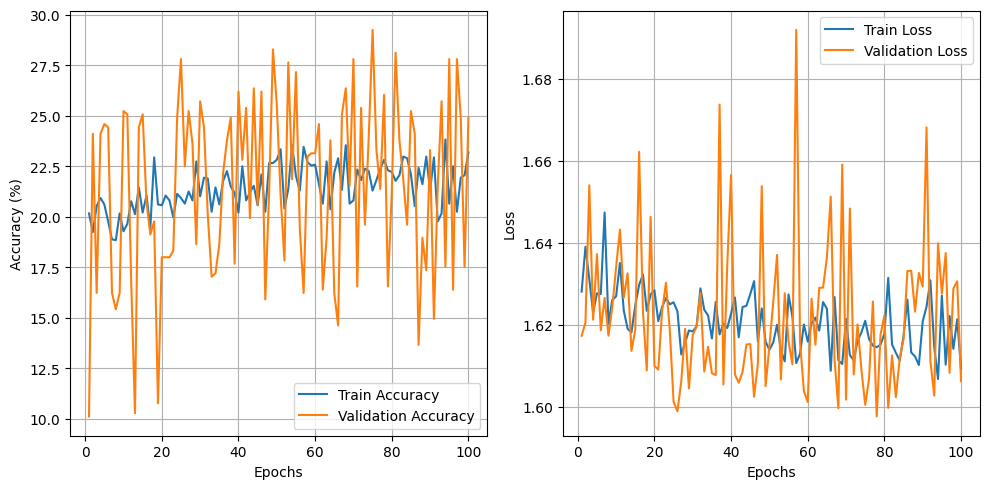

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/v3/representacion_3/longitud_8/{nombre_modelo}.png')
plt.show()

***Cargar el modelo :***

In [10]:
#modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)

modelo.load_state_dict(torch.load("./Modelos/v3/representacion_3/longitud_8/ConvNext_Tiny_fold_1.pth"))
modelo.to(device)
modelo.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

***Evaluar el modelo :***

In [11]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelo(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Matriz de confusión :***

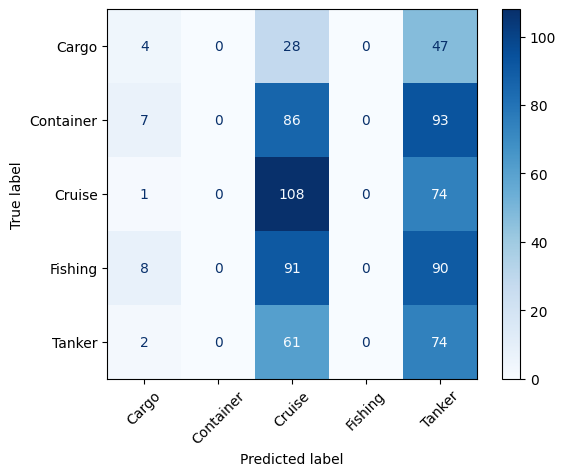

In [12]:
class_names = ['Cargo','Container','Cruise','Fishing','Tanker']
#class_names = ['Cargo', 'Container','Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [13]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v3/representacion_3/longitud_8')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'ConvNext_Tiny_report', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

       Cargo       0.18      0.05      0.08        79
   Container       0.00      0.00      0.00       186
      Cruise       0.29      0.59      0.39       183
     Fishing       0.00      0.00      0.00       189
      Tanker       0.20      0.54      0.29       137

    accuracy                           0.24       774
   macro avg       0.13      0.24      0.15       774
weighted avg       0.12      0.24      0.15       774



c:\Users\jesus\OneDrive\Escritorio\TFG\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jesus\OneDrive\Escritorio\TFG\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jesus\OneDrive\Escritorio\TFG\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i